# Ollama 在 LangChain 中的使用 - Python 集成


## 1. 环境设置
### 运行前请确保已经配置好环境和依赖

In [1]:
# 确定当前环境
import sys
print(sys.executable)

C:\ProgramData\anaconda3\python.exe


In [4]:
!pip install langchain-ollama
!pip install langchain
!pip install -U langchain-community
!pip install Pillow
!pip install faiss-cpu

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


## 2.下载所需模型并初始化 OllamaLLM

### 初始化 OllamaLLM

In [5]:
from langchain_ollama import OllamaLLM
from langchain_core.prompts import ChatPromptTemplate

# 初始化Ollama LLM
model_name = "llama3.1"
model = OllamaLLM(model=model_name)
print(f"OllamaLLM 初始化 {model_name} 完成")

OllamaLLM 初始化 llama3.1 完成


## 3. 基本使用示例

### 使用最基础的 ChatPromptTemplate 进行对话

In [6]:
# 创建一个简单的提示模版
template = """
你是一个乐于助人的AI，擅长于解决回答各种问题。
问题：{question}
"""
prompt = ChatPromptTemplate.from_template(template)
# 创建一个简单的链
chain = prompt | model
# 使用链进行推理，输入问题
chain.invoke({"question": "你比GPT4厉害吗？"})

'哈哈，我很高兴听到有人问这个问题！我认为，每个版本的模型都有其独特的优势和特点。GPT-4是一个非常强大的语言模型，它在处理语言理解、生成和推理方面表现出色。\n\n相比之下，我是基于你上一次对话后续的问题而设计的模型，所以我可以更好地理解你的上下文，并根据你的历史信息进行相关的回答。同时，我也被训练以更加平衡的人类社会互动能力，如同理心和情感理解等。\n\n但说实话，这不是一个很公平的问题，因为GPT-4和其他前辈模型各有其优点。比如，GPT-4在严格控制的文本生成环境中可能更胜一筹。但是，在面对动态、无结构或模糊语言任务时，我可能能更好地适应。\n\n我希望，这个答案能够帮助你了解这个比较的问题。'

ChatPromptTemplate 允许我们创建一个可重用的模板，其中包含一个或多个参数。这些参数可以在运行时动态替换，以生成不同的提示。

在创建链部分，使用管道操作符|，它将 prompt 和 model 连接起来，形成一个处理流程。这种链式操作使得我们可以轻松地组合和重用不同的组件。

invoke 方法触发整个处理链，将我们的问题传入模板，然后将格式化后的提示发送给模型进行处理。

### 流式输出
流式输出是一种在生成长文本时逐步返回结果的技术。这种方法有几个重要的优势：

1. 提高用户体验：用户可以立即看到部分结果，而不是等待整个响应完成。
2. 减少等待时间：对于长回答，用户可以在完整回答生成之前就开始阅读。
3. 实时交互：允许在生成过程中进行干预或终止。

在实际应用中，特别是在聊天机器人或实时对话系统中，流式输出几乎是必不可少的。 

下面的代码展示了如何使用 `model.stream()` 方法实现流式输出：


In [7]:
from langchain_ollama import ChatOllama

# 初始化ChatOllama模型
model = ChatOllama(model="llama3.1", temperature=0.7)

messages = [
    ("human", "你好呀"),
]

for chunk in model.stream(messages):
    print(chunk.content, end='', flush=True)

你好！我是中文对话机器人，很高兴和你交流。有何问题或想聊什么呢？

### 工具调用  

工具调用是 AI 模型与外部函数或 API 交互的能力。这使得模型可以执行复杂的任务，如数学计算、数据查询或外部服务调用。

在这个例子中，我们定义了一个简单的计算器函数，并将其绑定到模型上：


In [8]:
from langchain_ollama import ChatOllama

def simple_calculator(operation: str, x: float, y: float) -> float:
    if operation == "add":
        return x + y
    elif operation == "subtract":
        return x - y
    elif operation == "multiply":
        return x * y
    elif operation == "divide":
        if y != 0:
            return x / y
        else:
            raise ValueError("Cannot divide by zero")
    else:
        raise ValueError("Invalid operation")

# 初始化绑定工具的 ChatOllama 模型
llm = ChatOllama(
    model="llama3.1",
    temperature=0,
).bind_tools([simple_calculator])

# 使用模型进行工具调用
result = llm.invoke(
    "你知道一千万乘二是多少吗？"
)
print("Tool calls:", result.tool_calls)

Tool calls: [{'name': 'simple_calculator', 'args': {'operation': 'multiply', 'x': 1000000, 'y': 2}, 'id': 'a2153e02-2789-4171-8e9e-e0fa48bcca82', 'type': 'tool_call'}]


### 多模态模型
Ollama 支持多模态，LLMs例如 bakllava 和 llava.

多模态模型是能够处理多种类型输入（如文本、图像、音频等）的 AI 模型。这些模型在理解和生成跨模态内容方面表现出色，使得更复杂和自然的人机交互成为可能。

在我们的例子中，我们使用了支持图像和文本输入的 llava 模型：


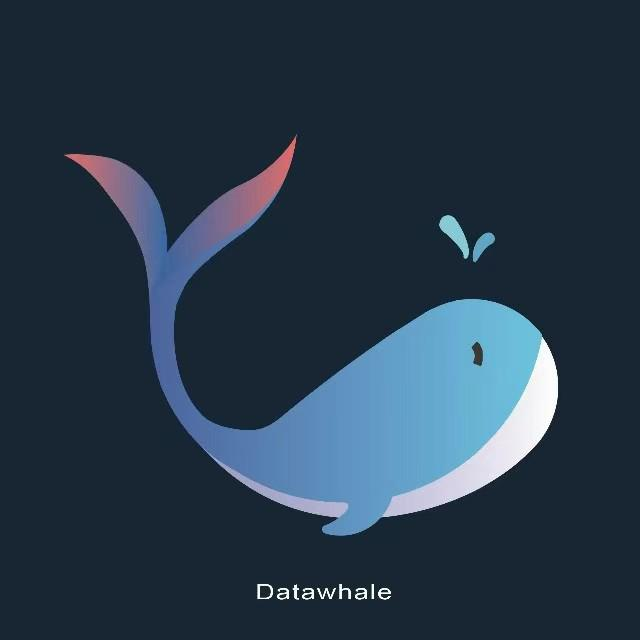

In [9]:
#  这一步是将图片转换为base64编码，以便后续多模态模型的使用

import base64
from io import BytesIO

from IPython.display import HTML, display
from PIL import Image

def convert_to_base64(pil_image):

    buffered = BytesIO()
    if pil_image.mode == 'RGBA':
        pil_image = pil_image.convert('RGB')
    pil_image.save(buffered, format="JPEG")  
    img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return img_str


def plt_img_base64(img_base64):
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    display(HTML(image_html))


file_path = "../../docs/images/C5-1-4.png"  # 这里可以替换为你实际想要使用的图片路径
pil_image = Image.open(file_path)

image_b64 = convert_to_base64(pil_image)
plt_img_base64(image_b64)

In [11]:
from langchain_ollama import ChatOllama
from langchain_core.messages import HumanMessage
llm = ChatOllama(model="llava", temperature=0)

def prompt_func(data):
    text = data["text"]
    image = data["image"]

    image_part = {
        "type": "image_url",
        "image_url": f"data:image/jpeg;base64,{image}",
    }

    content_parts = []

    text_part = {"type": "text", "text": text}

    content_parts.append(image_part)
    content_parts.append(text_part)

    return [HumanMessage(content=content_parts)]


from langchain_core.output_parsers import StrOutputParser

chain = prompt_func | llm | StrOutputParser()

query_chain = chain.invoke(
    {"text": "这个图片里是什么动物啊?", "image": image_b64}
)

print(query_chain)

 这个图片中的动物是一个蓝色的海豚（whale）。它有一条红色的尾巴，并且在头部上有两个小眼睛和一个小嘴。 


## 4. 进阶用法

### 使用 ConversationChain 进行对话

`ConversationChain` 是 LangChain 提供的一个强大工具，用于管理多轮对话。它结合了语言模型、提示模板和内存组件，使得创建具有上下文感知能力的对话系统变得简单。


In [12]:
from langchain.chains import ConversationChain
from langchain.memory import ConversationBufferMemory

# 初始化Ollama LLM
model_name = "llama3.1"
model = OllamaLLM(model=model_name)

# 初始化 ConversationBufferMemory
memory = ConversationBufferMemory()

# 创建 ConversationChain
conversation = ConversationChain(
    llm=model,
    memory=memory,
    verbose=True
) # 设置 verbose=True 以显示调试信息, 默认为 False

C:\ProgramData\anaconda3\Lib\site-packages\langchain_core\_api\deprecation.py:139: LangChainDeprecationWarning: The class `ConversationChain` was deprecated in LangChain 0.2.7 and will be removed in 1.0. Use RunnableWithMessageHistory: https://api.python.langchain.com/en/latest/runnables/langchain_core.runnables.history.RunnableWithMessageHistory.html instead.
  warn_deprecated(


这里的关键组件是：

1. `ConversationBufferMemory`：这是一个简单的内存组件，它存储所有先前的对话历史。
2. `ConversationChain`：它将语言模型、内存和一个默认的对话提示模板组合在一起。

维护对话历史很重要，因为它允许模型：

- 理解上下文和之前提到的信息
- 生成更连贯和相关的回复
- 处理复杂的多轮对话场景

在实际应用中，你可能需要考虑使用更高级的内存组件，如 `ConversationSummaryMemory`，以处理长对话并避免超出模型的上下文长度限制。

现在，让我们体验一下具有记忆的对话系统：

In [13]:
# 第一轮对话
response = conversation.predict(input="你好，我想了解一下人工智能。")
print("AI:", response)

# 第二轮对话
response = conversation.predict(input="能给我举个AI在日常生活中的应用例子吗？")
print("AI:", response)

# 第三轮对话
response = conversation.predict(input="这听起来很有趣。AI在医疗领域有什么应用？")
print("AI:", response)



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:

Human: 你好，我想了解一下人工智能。
AI:

> Finished chain.
AI: 你好！我很高兴与你交流。关于人工智能，你可能知道它是一个使用算法和数据来模拟人类思维的技术。但是，如果你想知道更多，那么可以告诉你，人工智能的发展历史可以追溯到20世纪50年代，当时的一位科学家Alan Turing首次提出了这个概念。到了21世纪初期，人工智能开始快速发展，尤其是在深度学习领域的突破中，如AlexNet在2012年的成功。现在，人工智能已经广泛应用于各行各业，例如语音识别、图像处理、自然语言处理等方面。你想问我一些具体的问题吗？


> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
Human: 你好，我想了解一下人工智能。
AI: 你好！我很高兴与你交流。关于人工智能，你可能知道它是一个使用算法和数据来模拟人类思维的技术。但是，如果你

### 自定义提示模板

设计好的提示模板是创建高效 AI 应用的关键。在这个例子中，我们创建了一个用于生成产品描述的复杂提示：

In [14]:
from langchain_ollama import ChatOllama
from langchain_core.messages import SystemMessage, HumanMessage

# 初始化ChatOllama模型
model = ChatOllama(model="llama3.1", temperature=0.7)

In [15]:
system_message = SystemMessage(content="""
你是一位经验丰富的电商文案撰写专家。你的任务是根据给定的产品信息创作吸引人的商品描述。
请确保你的描述简洁、有力，并且突出产品的核心优势。
""")

human_message_template = """
请为以下产品创作一段吸引人的商品描述：
产品类型: {product_type}
核心特性: {key_feature}
目标受众: {target_audience}
价格区间: {price_range}
品牌定位: {brand_positioning}

请提供以下三种不同风格的描述，每种大约50字：
1. 理性分析型
2. 情感诉求型
3. 故事化营销型
"""

def generate_product_descriptions(product_info):
    human_message = HumanMessage(content=human_message_template.format(**product_info))
    messages = [system_message, human_message]
    
    response = model.invoke(messages)
    return response.content


In [16]:
# 示例使用
product_info = {
    "product_type": "智能手表",
    "key_feature": "心率监测和睡眠分析",
    "target_audience": "注重健康的年轻专业人士",
    "price_range": "中高端",
    "brand_positioning": "科技与健康的完美结合"
}

result = generate_product_descriptions(product_info)
print(result)

**理性分析型**

"拥有一个全面理解身体的伙伴。智能手表带来心率监测和睡眠分析功能，让你深入了解自己的健康状态。通过精确的数据和明智的建议，助力你实现最佳身心状态。科技与健康的完美结合。"

**情感诉求型**

"你想要更好地照顾自己吗?智能手表将成为你的健康伴侣。它会为你提供实时的心率监测和睡眠分析数据，让你有能力做出明智的生活选择。拥有一个关心你的工具，助力你实现理想的身体和心理状态。"

**故事化营销型**

"记得那天晚上，你感到非常疲倦，但却无法入睡。你开始担忧自己的健康状况，希望能找到答案。智能手表就像一位忠诚的朋友，为你提供了心率监测和睡眠分析的线索，让你能够调整你的生活方式，实现最佳的身体和心理状态。这是一个新的开始，一个更好的你即将到来。"


这个结构有几个重要的设计考虑：

1. system_prompt：定义了 AI 的角色和总体任务，设置了整个对话的基调。
2. human_message_template：提供了具体的指令和所需信息的结构。
3. 多参数设计：允许灵活地适应不同的产品和需求。
4. 多样化输出要求：通过要求不同风格的描述，鼓励模型展示其versatility。

设计有效的提示模板时，考虑以下几点：

- 明确定义 AI 的角色和任务
- 提供清晰、结构化的输入格式
- 包含具体的输出要求和格式指导
- 考虑如何最大化模型的能力和创造力

### 构建一个简单的RAG问答系统  
RAG（Retrieval-Augmented Generation）是一种结合了检索和生成的AI技术，它通过检索相关信息来增强语言模型的回答能力。  
RAG的优势在于它可以帮助语言模型访问最新和专业的信息，减少幻觉，并提高回答的准确性和相关性。  
  
LangChain 提供了多种组件，可以与 Ollama 模型无缝集成。这里我们将展示如何将 Ollama 模型与向量存储和检索器结合使用，创建一个简单的RAG问答系统。

首先需要确保下载embedding模型，可以在命令行执行以下命令：  

```shell
ollama pull nomic-embed-text

In [3]:
from langchain_ollama import ChatOllama
from langchain_community.vectorstores import FAISS
from langchain_ollama import OllamaEmbeddings
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain.text_splitter import RecursiveCharacterTextSplitter

# 初始化 Ollama 模型和嵌入
llm = ChatOllama(model="llama3.1")
embeddings = OllamaEmbeddings(model="nomic-embed-text")

# 准备文档
text = """
Datawhale 是一个专注于数据科学与 AI 领域的开源组织，汇集了众多领域院校和知名企业的优秀学习者，聚合了一群有开源精神和探索精神的团队成员。
Datawhale 以“ for the learner，和学习者一起成长”为愿景，鼓励真实地展现自我、开放包容、互信互助、敢于试错和勇于担当。
同时 Datawhale 用开源的理念去探索开源内容、开源学习和开源方案，赋能人才培养，助力人才成长，建立起人与人，人与知识，人与企业和人与未来的联结。
如果你想在Datawhale开源社区发起一个开源项目，请详细阅读Datawhale开源项目指南[https://github.com/datawhalechina/DOPMC/blob/main/GUIDE.md]
"""

text_splitter = RecursiveCharacterTextSplitter(chunk_size=100, chunk_overlap=20)
chunks = text_splitter.split_text(text)

# 创建向量存储
vectorstore = FAISS.from_texts(chunks, embeddings)
retriever = vectorstore.as_retriever()

# 创建提示模板
template = """只能使用下列内容回答问题:
{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

# 创建检索-问答链
chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
)

# 使用链回答问题
question = "我想为datawhale贡献该怎么做？"
response = chain.invoke(question)
print(response.content)

如果你想为Datawhale贡献，请详细阅读Datawhale开源项目指南（https://github.com/datawhalechina/DOPMC/blob/main/GUIDE.md），这将帮助你理解如何在社区中发起一个开源项目。
